In [10]:
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_normal
from mynn.optimizers.sgd import SGD
import random
import mygrad as mg
from langwahge import *
%matplotlib inline

class Model:
    def __init__(self, input_dim, output_dim):
        """ Initializes all of the encoder and decoder layers in our model, setting them
        as attributes of the model.
        
        Parameters
        ----------
        context_words : int
            The number of context words included in our vocabulary
            
        d : int
            The dimensionality of our word embeddings
        """
        # STUDENT CODE HERE
        self.encoder = dense(input_dim,output_dim, weight_initializer = glorot_normal, bias = False)
    
    def __call__(self, x):
        ''' Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, context_words)
            A batch of data consisting of M words from the context matrix,
                each tracking the number of co-occurences with `context_words` words.
                
        Returns
        -------
        mygrad.Tensor, shape=(M, context_words)
            The result of passing the data through borth the encoder and decoder.
        '''
        # STUDENT CODE HERE
        
        normal_this = self.encoder(x)
        normal = mg.sqrt((normal_this**2).sum(keepdims = True))
        return normal 
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        # STUDENT CODE HERE
        return self.encoder.parameters

C:\Users\nicho\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


IndentationError: unindent does not match any outer indentation level (database.py, line 144)

In [6]:
def loss_accuracy(sim_match, sim_confuse, threshold, triplets = 0):
    #loss = max(0, threshold - (sim_match - sim_confuse))
    
    loss = mygrad.nnet.losses.margin_ranking_loss(sim_match, sim_confuse, threshold)
    #list_to_sum = [1 if sim_match>sim_confuse else 0 for i in triplets]
    #acc = sum(list_to_sum)/len(triplets)
    return loss#, acc

In [7]:
model = Model(input_dim = 512, output_dim = 200)
optim = SGD(model.parameters, learning_rate = 1e-3, momentum = 0.9)

NameError: name 'coco_data' is not defined

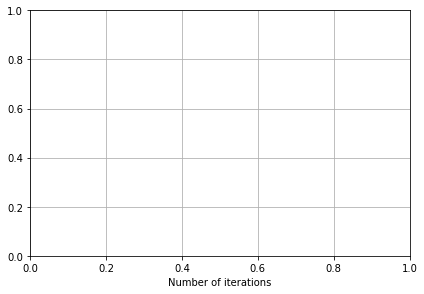

In [8]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"], max_fraction_spent_plotting=.75)

batch_size = 32

data = coco_data()
coco_data, glove, resnet18_features, imgid_to_capid, capid_to_imgid, capid_to_capstr, counters = data.get_self()
#split the data
split_at = 0.75
keyslist = list(resnet18_features.keys())
split = int(len(keyslist)*split_at)
training_keys = keyslist[:split]      #if this doesn't work for some reason could just hardcode

training_vectors = [resnet18_features[i] for i in training_keys]

training_captions_id = [imgid_to_capid[i] for i in training_keys]

training_captions = [capid_to_capstr[i] for i in training_captions_id]

# test_vectors = resnet18_features[split:82600]
# test_captions = 

testing_keys = keyslist[split:82600]

testing_vectors = [resnet18_features[i] for i in testing_keys]

testing_captions_id = [imgid_to_capid[i] for i in testing_keys]

testing_captions = [capid_to_capstr[i] for i in testing_captions_id]

match = 0
triplets = 0
for epoch in range(10000):
    indexes = np.arange((len(training_vectors)))
    np.random.shuffle(indexes)
    for batch_count in range(0,len(training_vectors)//batch_size):
        batch_indexes = indexes[batch_count*batch_size: batch_count*(batch_size+1)]
        batch = training_vectors[batch_indexes]  
#         print(batch)
        w_caption = training_captions[i]  #should correspond to the vectors
        prediction = model(batch)
        
        confuser = model(resnet18_features[random.choice(list(resnet18_features.keys())[:82600])])  
        
        sim_match = w_caption@prediction
        sim_confuse = w_caption@confuser
        
        if sim_match>sim_confuse:  #accuracy?
            match+=1
        triplets+=1
        
        loss = loss_accuracy(sim_match, sim_confuse, 0.25)
        
        loss.backward()
        
        optim.step()
        
        #acc =  np.mean(np.argmax(prediction, axis=1) == batch)
        
        plotter.set_train_batch({"loss" : loss.item()
                                 },
                                 batch_size=batch_size)
accuracy = match/triplets

In [ ]:
#testing
length_total = defaultdict(int)
length_correct = defaultdict(int)

with mg.no_autodiff:
    for i in range(10000):
        if i % 5000 == 0:
            print(f"i = {i}")
        #x, target, sequence = generate_batch(1, 20, 1)
        x = test_vectors[i]
        output = model(x)

        length_total[sequence.size] += 1
        if np.all(np.argmax(output, axis=-1) == target):
            length_correct[sequence.size] += 1

fig, ax = plt.subplots()
x, y = [], []
for i in range(1, 20):
    x.append(i)
    y.append(length_correct[i] / length_total[i])
ax.plot(x, y);